In [1]:
# imports
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor


%matplotlib inline
plt.style.use('dark_background')

%matplotlib inline

In [2]:
# get asap data
data_folder = Path.cwd().parent.parent.joinpath('data', 'external')
df_asap = pd.read_csv(Path(data_folder).joinpath('asap','unit',
                                                 'asap_data_crop_gaul2.csv'), index_col = 0)



In [3]:
# get IPC data
df_ipc = pd.read_csv(Path(data_folder).joinpath('ipc_current.csv'))


In [4]:
df_ipc.drop(['adm1_name', 'phase_class'], axis=1, inplace=True)

In [5]:
# severity version 2
df_ipc['severity'] = (df_ipc['phase1'] + df_ipc['phase2']*2
                          + df_ipc['phase3']*4 + df_ipc['phase4']*8 +
                          df_ipc['phase5']*16 )/ df_ipc['population']

In [6]:

cols = list(df_ipc.columns)
cols[0] = 'unit_name'
df_ipc.columns = cols

In [7]:
df_ipc.sort_values('datetime', inplace=True)

In [8]:
df_ipc.head()

,unit_name,datetime,population,phase1,phase2,phase3,phase4,phase5,phase35,severity
0,Velingara,2014-01-01,289381.0,208354.0,57876.0,23150.0,0.0,0.0,23150.0,1.439991
23,Fatick,2014-01-01,391122.0,273785.0,109514.0,7431.0,391.0,0.0,7822.0,1.343992
24,Gossas,2014-01-01,122930.0,105105.0,14752.0,2459.0,615.0,0.0,3073.0,1.215041
25,Foundiougne,2014-01-01,324882.0,162441.0,153344.0,8122.0,975.0,0.0,9097.0,1.568006
26,Diourbel,2014-01-01,304132.0,197686.0,98539.0,7603.0,304.0,0.0,7907.0,1.405995


In [9]:
df_asap.head()

,unit_name,variable_name,date,value,year,month,day,yearday,dec_day
0,Kebemer,SPI - 3 months,19890621,2.480,1989,6,21,172,170
1,Kebemer,SPI - 3 months,19890701,1.370,1989,7,1,182,180
2,Kebemer,SPI - 3 months,19890711,1.723,1989,7,11,192,190
3,Kebemer,SPI - 3 months,19890721,1.310,1989,7,21,202,200
4,Kebemer,SPI - 3 months,19890801,0.751,1989,8,1,213,210


## Lets pick a distinguish region:
adepts:
- Kedougou
- Ranerou (Matam)
- Kanel

what about the weather data:

In [41]:
df_asap['unit_name'].unique().sort()

In [40]:
df_ipc['unit_name'].unique()

array(['Velingara', 'Fatick', 'Gossas', 'Foundiougne', 'Diourbel',
       'Bambey', 'Mbacke', 'Bakel', 'Goudiry', 'Guinguineo',
       'Koumpentoum', 'Mbour', 'Thies', 'Tivaouane', 'Bignona',
       'Oussouye', 'Ziguinchor', 'Bounkiling', 'Goudomp', 'Tambacounda',
       'Nioro Du Rip', 'Sedhiou', 'Koungheul', 'Kolda',
       'Medina Yoro Foulah', 'Louga', 'Linguere', 'Kebemer', 'Kaolack',
       'Podor', 'Saint Louis', 'Ranerou', 'Dagana', 'Kanel', 'Kedougou',
       'Saraya', 'Salemata', 'Rufisque', 'Kaffrine', 'Malem Hodar',
       'Birkelane', 'Matam', 'Pikine', 'Guediawaye', 'Dakar'],
      dtype=object)

In [ ]:
units = ['Kedougou', 'Ranerou', 'Kanel']

df_ipc[df_ipc['unit_name'] == 'Kedougou']

So lets set the start of the year as 100 dec_day (to be sure).


We have ground truth from two time spans:
- Sep - Dec
- Jan - May

Most warnings are issued in months from Jun-November, this is when an anomaly happens.
The outcome might onset with a delay. Lets not separate the data, and look at the season
from the day 100 (approximately from May) and we will try to perdict the state
in Jan - May next year.

In [11]:
temp = df_asap[df_asap['unit_name'] == units[0]]
temp = temp[temp['year']>=2012]

df_crop = temp[(temp['year'] >= 2012) & (temp['year'] <=2020)]


In [12]:
df_crop



,unit_name,variable_name,date,value,year,month,day,yearday,dec_day
22936,Kedougou,SPI - 3 months,20120101,-1.910,2012,1,1,1,0
22937,Kedougou,SPI - 3 months,20120501,-0.360,2012,5,1,122,120
22938,Kedougou,SPI - 3 months,20120511,1.271,2012,5,11,132,130
22939,Kedougou,SPI - 3 months,20120521,0.446,2012,5,21,142,140
22940,Kedougou,SPI - 3 months,20120601,-0.455,2012,6,1,153,150
...,...,...,...,...,...,...,...,...,...
25267,Kedougou,Temperature,20201011,26.535,2020,10,11,285,280
25268,Kedougou,Temperature,20201021,26.987,2020,10,21,295,290
25269,Kedougou,Temperature,20201101,27.984,2020,11,1,306,300
25270,Kedougou,Temperature,20201111,26.435,2020,11,11,316,310


In [13]:
start_season_day = 100
for i, row in df_crop.iterrows():
    y = int(row['year'])
    d = row['dec_day']
    df_crop.loc[i,'season_year'] = y if d > start_season_day else y-1
    df_crop.loc[i, 'season_dec_day'] = d-100 if d>start_season_day \
        else 360 - start_season_day+d

In [14]:
df_crop.head()

,unit_name,variable_name,date,value,year,month,day,yearday,dec_day,season_year,season_dec_day
22936,Kedougou,SPI - 3 months,20120101,-1.910,2012,1,1,1,0,2011.0,260.0
22937,Kedougou,SPI - 3 months,20120501,-0.360,2012,5,1,122,120,2012.0,20.0
22938,Kedougou,SPI - 3 months,20120511,1.271,2012,5,11,132,130,2012.0,30.0
22939,Kedougou,SPI - 3 months,20120521,0.446,2012,5,21,142,140,2012.0,40.0
22940,Kedougou,SPI - 3 months,20120601,-0.455,2012,6,1,153,150,2012.0,50.0


Scale

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
df_crop['unit_name'].unique()

array(['Kedougou'], dtype=object)

In [17]:
df_ipc_unit = df_ipc[df_ipc['unit_name'] == 'Kedougou']
# select only current situation from Jan to May
gt1 = df_ipc_unit[df_ipc_unit['datetime'].apply(lambda x: x[5:7] == '01')].copy()
gt1['season'] = gt1['datetime'].apply(lambda x: int(x[:4])-1)
gt1 = gt1[['season', 'severity']]
y = gt1['severity'].values
seasons = gt1['season']

In [18]:
df_crop = df_crop[['variable_name', 'value', 'season_year', 'season_dec_day']]

In [19]:
df_crop = df_crop[df_crop['season_year'] != 2011.0]

In [20]:
df_crop.set_index(['season_year', 'season_dec_day'], inplace=True)

In [21]:
scaler = StandardScaler()

In [22]:
gt1

,season,severity
12,2013,1.629998
59,2014,1.439996
100,2015,1.229997
143,2016,1.449995
199,2017,1.409986
221,2018,1.290003
265,2019,1.600024


In [23]:
x = []
for i in seasons:
    x_sample = df_crop.xs(i).reset_index()
    x_sample.drop_duplicates(subset=['season_dec_day', 'variable_name'], inplace=True)
    x_sample = x_sample.pivot('season_dec_day','variable_name','value')
    sample_cols = x_sample.columns
    x_sample = x_sample.values
    x.append(x_sample)

In [24]:
x = np.array(x)

In [25]:
x.shape

(7, 25, 6)

In [26]:
xx = np.empty((7,150))
for i in range(7):
    xx[i] = x[i,:,:].T.flatten()

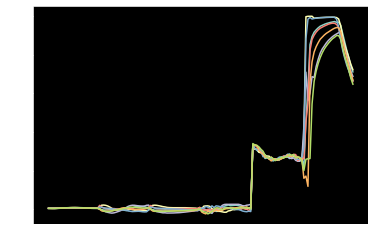

In [27]:
for i in range(7):
    plt.plot(xx[i])

In [28]:
scaler.fit(xx)
xx_scaled = scaler.transform(xx)

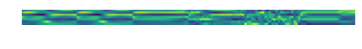

In [29]:
plt.imshow(xx_scaled)

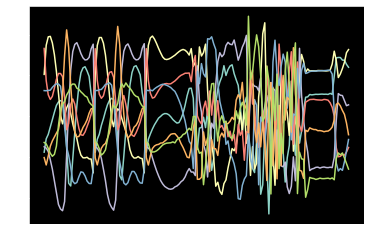

In [30]:
for i in range(7):
    plt.plot(xx_scaled[i])

In [2]:
x = np.load('/home/cajanond/Documents/omdena/GPSDD-Food-Security-Senegal/data/external/x_scaled.npy')
gt = np.load('/home/cajanond/Documents/omdena/GPSDD-Food-Security-Senegal/data/external/gt.npy')
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [6]:
x_regr = x.copy()
x_regr = np.swapaxes(x_regr, 1,2)
x_regr = x_regr.reshape(405, 36*12)

x_regr = np.nan_to_num(x_regr, nan=0)


array([[ 0.        ,  0.        ,  0.        , ..., -0.92628222,
        -0.96756913, -0.96756913],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ..., -0.79525223,
        -0.81918254, -0.84311286],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [5]:
xgb_model = xgb.XGBRegressor(n_jobs=1)
clf = GridSearchCV(xgb_model,
                   {'max_depth': [2, 4, 6],
                    'n_estimators': [50, 100, 200]}, verbose=1, n_jobs=1)
clf.fit(x_regr, gt)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [37]:
print(clf.best_score_)
print(clf.best_params_)

nan
{'max_depth': 2, 'n_estimators': 50}


In [50]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate, ShuffleSplit
from sklearn.pipeline import make_pipeline
max_depth = 10
regr = RandomForestRegressor(max_depth=max_depth, random_state=0)
regr.fit(xx[:4,:], y[:4])
pred = regr.predict(xx[4:,:])
mse = mean_squared_error(y[4:], pred)
print(f'True: {y[4:]}')
print(f'Pred: {pred}')
print(f'MSE: {mse}')

True: [1.40998648 1.29000303 1.60002428]
Pred: [1.46359597 1.44649615 1.44199653]
MSE: 0.01744561522652609


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/cajanond/anaconda3/envs/omdena_base/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/cajanond/anaconda3/envs/omdena_base/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/cajanond/anaconda3/envs/omdena_base/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
/home/cajanond/anaconda3/envs/omdena_base/lib/python3.7/site-packages/sklearn/metrics/_regression.py:594: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMe

GridSearchCV(estimator=RandomForestRegressor(), n_jobs=1,
             param_grid={'max_depth': [2, 4, 6]}, verbose=1)

In [53]:
clf = make_pipeline(StandardScaler(), RandomForestRegressor())
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
res = cross_validate(clf, xx, y, cv=cv, return_estimator=True,
                     scoring='neg_mean_squared_error')

In [54]:
res

{'fit_time': array([0.09439015, 0.07784534, 0.07741117, 0.09392715, 0.11300182]),
 'score_time': array([0.00526953, 0.00482917, 0.00470233, 0.00796843, 0.0052371 ]),
 'estimator': (Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())]),
  Pipeline(steps=[('standardscaler', StandardScaler()),
                  ('randomforestregressor', RandomForestRegressor())])),
 'test_score': array([-0.03094166, -0.05795178, -0.01779689, -0.06516895, -0.05088968])}

AttributeError: 'Pipeline' object has no attribute 'best_score_'

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(years_train, y_train, '*', label = 'train')
ax.plot(years_test, y_test, '<', label = 'test')
ax.plot(years_test, pred, 'x', label = 'pred')
ax.set_xlim(2012, 2020)
ax.legend()
ax.set_title(region)
ax.set_xlabel('year')
_ = ax.set_ylabel('severity')